In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
plt.style.use('ggplot')

def value_imputation(df, column_name, fill_value):
    '''
    Function to fill missing rows with specific value
    '''
    df[column_name] = df[column_name].fillna(fill_value) # which value to indicate missingnes
    return df

# Yellow cabs

## Initial data processing

In [121]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

## missing value imputation with values out of range of standard values that we can later recognize
df = (df
    .pipe(value_imputation, column_name='RatecodeID', fill_value=0)
    # gonna assume that it had to be stored in car if there was a problem with server connection
    .pipe(value_imputation, column_name='store_and_fwd_flag', fill_value='Y')
    # most of the time there there is a value of 2.5 so im gonna use it
    .pipe(value_imputation, column_name='congestion_surcharge', fill_value=2.5)
    # im gonna assume there is not airport fee, but mayby better idea is to do it by identifying starting district
    .pipe(value_imputation, column_name='airport_fee', fill_value=0)
    # passengers are problematic, for now assigning -1 value for problematics cases
    .pipe(value_imputation, column_name='passenger_count', fill_value=-1)
    # also adding simple information about traveling time in minutes
    .assign(trip_time_min=lambda x: (x['tpep_dropoff_datetime']-x['tpep_pickup_datetime'])/timedelta(minutes=1))
)

## removing columns with problematic dates, cases where pickup happend after dropoff
df = df.drop(index=df[(df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime'])].index)

# performing some filtering to remove observations with nonsense data, explaination in query
df = df[
    # only valid vendors
    (df['VendorID'].isin([1, 2]))
    # only valid zones
    & (df['DOLocationID'].between(1, 263))
    & (df['PULocationID'].between(1, 263))
    # valid dates, personly i found some cases from 2022-10 so idk what happend there
    & (df['tpep_dropoff_datetime'] >= '2023-01-01') & (df['tpep_dropoff_datetime'] <= '2023-02-01')
    & (df['tpep_pickup_datetime'] >= '2023-01-01') & (df['tpep_pickup_datetime'] <= '2023-02-01')
    # so there are cases with negative, or 0 passengers im not sure if the nyc taxi 
    # can work as delivery service that can transport other stuff than people so im gonna remove these cases
    # also i found information that https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page
    # there can be up to 4-5 passengers, and sometimes a child (so up to 6) can be transproted, also keeping my imputed indicator
    & ((df['passenger_count'].between(1, 6)) | (df['passenger_count'] == -1))
    # removing RatecodeID that is not in 0-6, where 0 is imputed value
    & (df['RatecodeID'].between(0, 6)) 
    # this takes only 2 value, we have imputed nulls wiht Y
    & (df['store_and_fwd_flag'].isin(['Y', 'N']))
    # payment type has meaning only for values from range 1-6, 
    & (df['payment_type'].between(1, 6)) 
    # below I make sure that certain variables are only non-negative values, I don't think they have meaning being negative
    & ((df['fare_amount'] >= 0) & (df['extra'] >= 0) & (df['tip_amount'] >= 0) & (df['tolls_amount'] >= 0) & (df['total_amount'] >= 0) )
    # taxes depending on metered rate in use, off or on, sometimes it has weird values so droping them
    & (df['mta_tax'].isin([0, 0.5])) & (df['congestion_surcharge'].isin([0, 2.5])) 
    & (df['airport_fee'].isin([0, 1.25]))
    # filter that is more of a logical explaination, I don't think that anyone will spend more than 1h in a 
    # cab traveling across city and 
    & (df['trip_time_min'] <= 60) & (df['trip_distance'] < 30)
    # also we can't do big distances in too little time (edge case)
    & (
        (df['trip_time_min'] >= 2) 
        # im gonna say like up to 3 miles in 2 minutes possible when traveling on empty road
        | ((df['trip_time_min'] <= 2) & (df['trip_distance'] <= 3))
    )
]

## filtering data to find "valid trip cases", explained in query
df = (df[(
    # trips that have 0 traveling and are in same district, most likely canceled ones
    # I want to remove observations that changed distrcit but have 0 traveling
    ((df['tpep_dropoff_datetime'] >= df['tpep_pickup_datetime']) & (df['trip_distance'] == 0) & (df['PULocationID'] == df['DOLocationID']))
    # or trips between districts, ie they took some time to travel, distance and start end areas changes
    | ((df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']) & (df['trip_distance'] > 0) & (df['PULocationID'] != df['DOLocationID']))
    # there may also be trips within a district so lets keep them as long as there is some kind of traveling involved
    | ((df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']) & (df['trip_distance'] > 0) & (df['PULocationID'] == df['DOLocationID']))
)])

## adding up the Borough to dataset
df_zones = pd.read_csv('../data/taxi_zones/taxi+_zone_lookup.csv').iloc[:-2, :]
df_zones['Borough'] = df_zones['Borough'].astype('category')

df = (df
    # adding columns that can be used to indicate starting REGION
    .merge(df_zones[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID')
    .drop(columns='LocationID').rename(columns={'Borough': 'PU_Borough'})
    # adding columns that can be used to indicate destination REGION
    .merge(df_zones[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID')
    .drop(columns='LocationID').rename(columns={'Borough': 'DO_Borough'})
)


# variables that could be mainpulated but currently I have not idea how to use them
# - improvement_surcharge - it says 0.3 should be most of the time but its not?

print(len(df))
df.head()

2817985


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time_min,PU_Borough,DO_Borough
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.433333,Manhattan,Manhattan
1,2,2023-01-01 00:21:43,2023-01-01 00:27:52,1.0,2.00,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,15.00,2.5,0.0,6.150000,Manhattan,Manhattan
2,2,2023-01-01 00:11:44,2023-01-01 00:20:38,2.0,1.83,1.0,N,161,141,1,...,0.5,1.64,0.0,1.0,18.04,2.5,0.0,8.900000,Manhattan,Manhattan
3,2,2023-01-01 00:35:52,2023-01-01 00:43:38,2.0,1.41,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,15.00,2.5,0.0,7.766667,Manhattan,Manhattan
4,1,2023-01-01 00:51:12,2023-01-01 00:59:38,1.0,1.80,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,15.00,2.5,0.0,8.433333,Manhattan,Manhattan


## Exploration

### Time vs distance

After initial preprocessing there is still a little bit of wierd observations left with short time and long distances, but I'm gonna keep them for now

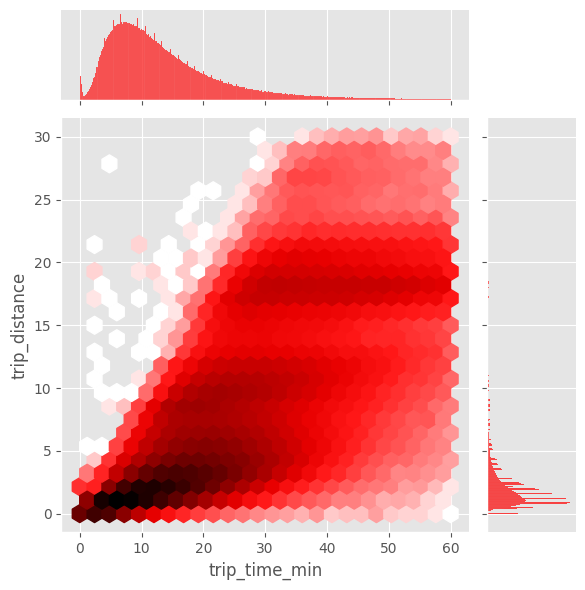

In [122]:
sns.jointplot(df, x='trip_time_min', y='trip_distance', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25))

### time trip vs cost

So this one is definetly interesting, time trip vs cost. There are some clear outlier, with insane costs, I actually wonder if these are some kind of penalties rather than wrongly entered data.

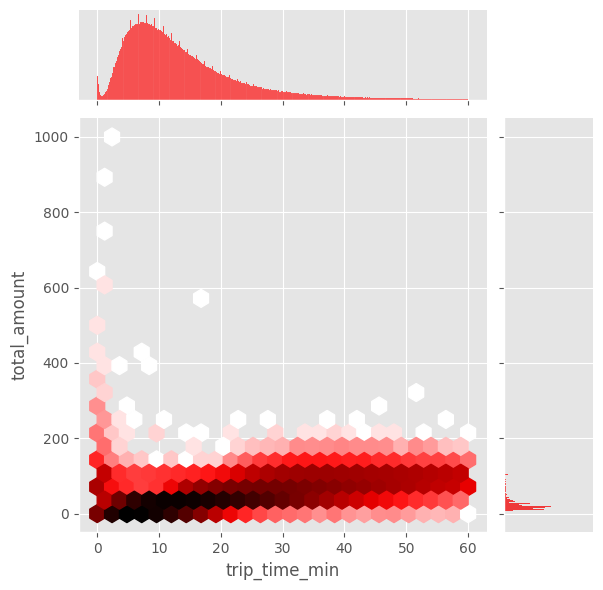

In [123]:
sns.jointplot(df, x='trip_time_min', y='total_amount', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25))

### trip distance vs total amount

So even more outliers, short trips with high costs, and long trips with near zero cost.

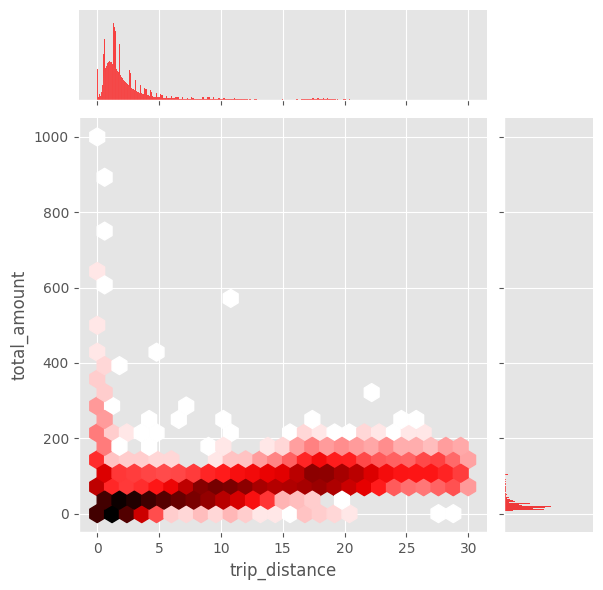

In [124]:
sns.jointplot(df, x='trip_distance', y='total_amount', kind="hex", color='red', ratio=4,
              joint_kws=dict(bins='log', gridsize=25))

In [7]:
with pd.option_context('display.max_columns', None):
    display(df.head(5))

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time_min
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.0,0.5,15.00,0.0,1.0,34.90,2.5,0.0,12.750000
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0,10.833333
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0,12.300000


## Where are people traveling

NYC Yellow cabs main operating area is located in the center of Manhattan, most of the people are picked up from Manhatten and are driven outside or around Manhattan. 

In [125]:
display(
    'Where are the passengers picked up?',
    df.groupby(['PU_Borough']).size().reset_index(),
    'Where are the passengers traveling to?',
    df.groupby(['DO_Borough']).size().reset_index(),
)

'Where are the passengers picked up?'

,PU_Borough,0
0,Bronx,1106
1,Brooklyn,10168
2,EWR,338
3,Manhattan,2553650
4,Queens,252633
5,Staten Island,90


'Where are the passengers traveling to?'

,DO_Borough,0
0,Bronx,13960
1,Brooklyn,103469
2,EWR,6349
3,Manhattan,2556425
4,Queens,137237
5,Staten Island,545


Start and end by specific boroughs

In [109]:
df.groupby(['PU_Borough', 'DO_Borough']).size().reset_index()

,PU_Borough,DO_Borough,0
0,Bronx,Bronx,794
1,Bronx,Brooklyn,9
2,Bronx,EWR,1
3,Bronx,Manhattan,259
4,Bronx,Queens,44
5,Bronx,Staten Island,0
6,Brooklyn,Bronx,18
7,Brooklyn,Brooklyn,5710
8,Brooklyn,EWR,19
9,Brooklyn,Manhattan,3823


## Number of trips by day of week

Interestingly I expected the number of trips to be the greatest in Friday and Saturday, note that this is January data, and the new year party was on Sunday, so seeing Tuesday toping the list is rather weird.

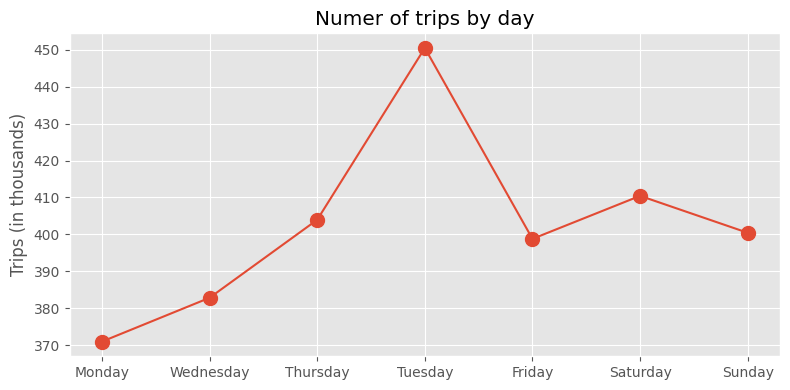

In [180]:
days_of_week = ['Monday', 'Wednesday', 'Thursday', 'Tuesday', 'Friday', 'Saturday', 'Sunday']
x = df.groupby([df['tpep_pickup_datetime'].dt.day_name()]).size()[days_of_week]/1000

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, '-o', ms=10),  ax.set_ylabel('Trips (in thousands)')
ax.set_title('Numer of trips by day')
fig.tight_layout()

## Number of trips by hours

Seems pretty much as expected, increasing number of trips past 5 am, as people return to home from work the number of trips increases, and falls again around 6 pm.

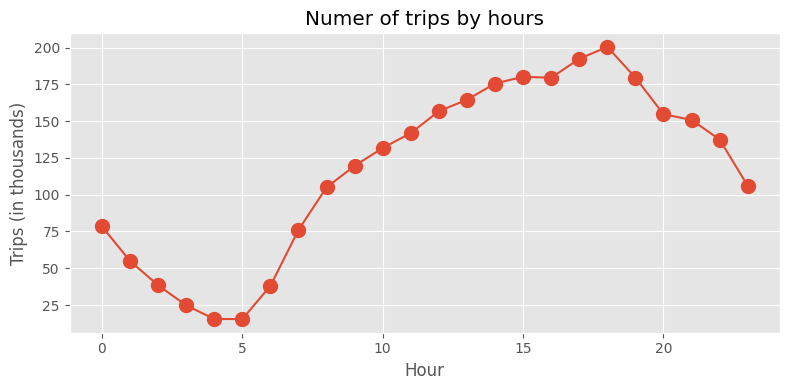

In [181]:
x = df.groupby([df['tpep_pickup_datetime'].dt.hour]).size()/1000

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x, '-o', ms=10), ax.set_xlabel('Hour'), ax.set_ylabel('Trips (in thousands)')
ax.set_title('Numer of trips by hours')
fig.tight_layout()

## Number of trips depending on day and hour

Some observations based on this data:
- Saturday, Sunday has the most early morning trips most likely people returning from parties
- Friday, Saturday most late night trips of people going to parties
- Tuesday has the most trips during the day and obviously people are not traveling as much on Saturday and Sunday during the day

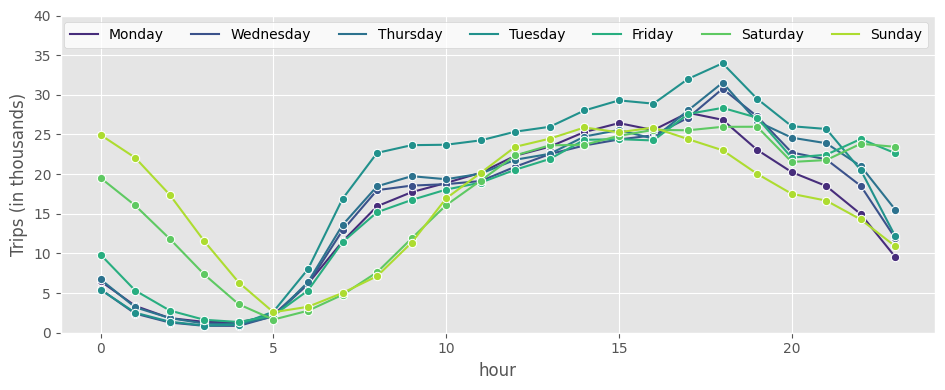

In [229]:
x = (
    df.groupby(
        [df['tpep_pickup_datetime'].dt.day_name(), df['tpep_pickup_datetime'].dt.hour]
    ).size()[days_of_week]
    .rename_axis(['day', 'hour']).reset_index().rename(columns={0: 'count'})
)
x['count'] = x['count']/1000

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(x, x='hour', y='count', hue='day', palette='viridis', marker='o')
plt.legend(ncol=7, facecolor='white'), ax.set_ylim((0, 40)), ax.set_ylabel('Trips (in thousands)')
fig.tight_layout()

# Conclusions

- What are the key factors contribution to the price of a trip
- I should also take a closer look the outliers found in amount vs distance, mayby they are oriented with some kind of late drives where drunk people broke something in a cab?
- Models should include day and hour factor if we want to know the expected number of taxi calls in particular area so that we can allocate resources.

In [126]:
shapefile = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
shapefile

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


# Green taxis

In [ ]:
# df = pd.read_parquet('../data/green_tripdata_2023-01.parquet')